In [1]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('finally2.csv')

In [2]:
df.head()

,cntr_grnds_dstnc,frstn_grnds_dstnc,hr_unit_artmp,hr_unit_hum,hr_unit_wspd_info,growing_stock,forest_ratio,avg_growing_stock,t2m_mean_c,t2m_min_c,...,fnd_igtn_pstn_nm_plain,wndrct_brng_NONE,wndrct_brng_south,wndrct_brng_southeast,wndrct_brng_southwest,wndrct_brng_east,wndrct_brng_north,wndrct_brng_northeast,wndrct_brng_northwest,wndrct_brng_west
0,1.609438,2.484907,-1.0,39.0,1,30500,22.81,81.77,-3.034902,-5.790863,...,0,0,0,0,0,0,0,0,1,0
1,1.098612,1.609438,5.0,60.0,1,30500,22.81,81.77,4.081675,-0.366791,...,0,0,0,0,1,0,0,0,0,0
2,1.791759,2.302585,7.0,49.0,1,30500,22.81,81.77,5.162099,0.126862,...,0,0,0,0,1,0,0,0,0,0
3,1.098612,1.791759,0.3,48.0,3,512610,70.18,148.11,3.929311,-0.390961,...,0,0,0,0,0,0,0,0,1,0
4,2.397895,3.295837,-8.7,36.0,5,9313181,78.60,179.32,-5.911774,-7.743500,...,1,0,0,0,0,0,0,0,0,1


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# 파일 경로
CSV_PATH = "finally2.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "fire_supesn_hr"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 모델에서 제외할 컬럼(있으면 제거)
EXCLUDE_COLS = {
    "total_time", "fire_supesn_hr", "relax_diff", "wind_speed_mean",
    TARGET  # 타깃은 당연히 피처에서 제외
}

# 숫자형 컬럼만 사용(원-핫 완료 가정) + 제외 컬럼 제거
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

# 필요 시 누수 변수 제거 (새 데이터에 없으면 자동 무시)
LEAKY_COL = "ARRIVAL_DELAY_MIN_LOG"
if not INCLUDE_LEAKY and LEAKY_COL in feature_cols:
    feature_cols.remove(LEAKY_COL)

# 안전장치: 피처가 하나도 없으면 에러
if len(feature_cols) == 0:
    raise ValueError("선택된 피처가 없습니다. EXCLUDE_COLS 또는 전처리를 확인하세요.")

print(f"선택된 피처 수: {len(feature_cols)}")
print("제외된 컬럼(데이터에 존재했던 항목만):",
      sorted([c for c in EXCLUDE_COLS if c in df.columns]))

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")


행: 3,560, 열: 65

컬럼명:
 ['cntr_grnds_dstnc', 'frstn_grnds_dstnc', 'hr_unit_artmp', 'hr_unit_hum', 'hr_unit_wspd_info', 'growing_stock', 'forest_ratio', 'avg_growing_stock', 't2m_mean_c', 't2m_min_c', 't2m_max_c', 'd2m_mean_c', 'd2m_min_c', 'd2m_max_c', 'u10_mean_ms', 'v10_mean_ms', 'wind_speed_mean', 'wind_dir_deg', 'tp_sum_mm', 'pev_sum_mm', 'ssrd_sum_jm2', 'ssrd_sum_mjm2', 'impute_radius', 'land', 'arrival_time_diff', 'dispatch_time_diff', 'golden_time_under_50min', 'is_night', 'month_rcpt', 'dspt_req_hr', 'fire_supesn_hr', 'ctpv_nm_gangwon', 'ctpv_nm_gyeonggi', 'ctpv_nm_gyeongnam', 'ctpv_nm_gyeongbuk', 'ctpv_nm_gwangju', 'ctpv_nm_daegu', 'ctpv_nm_daejeon', 'ctpv_nm_busan', 'ctpv_nm_seoul', 'ctpv_nm_sejong', 'ctpv_nm_ulsan', 'ctpv_nm_incheon', 'ctpv_nm_jeonnam', 'ctpv_nm_jeonbuk', 'ctpv_nm_jeju', 'ctpv_nm_chungnam', 'ctpv_nm_chungbuk', 'fclt_plc_sclsf_nm_public', 'fclt_plc_sclsf_nm_national']  ...


,cntr_grnds_dstnc,frstn_grnds_dstnc,hr_unit_artmp,hr_unit_hum,hr_unit_wspd_info,growing_stock,forest_ratio,avg_growing_stock,t2m_mean_c,t2m_min_c,...,fnd_igtn_pstn_nm_plain,wndrct_brng_NONE,wndrct_brng_south,wndrct_brng_southeast,wndrct_brng_southwest,wndrct_brng_east,wndrct_brng_north,wndrct_brng_northeast,wndrct_brng_northwest,wndrct_brng_west
0,1.609438,2.484907,-1.0,39.0,1,30500,22.81,81.77,-3.034902,-5.790863,...,0,0,0,0,0,0,0,0,1,0
1,1.098612,1.609438,5.0,60.0,1,30500,22.81,81.77,4.081675,-0.366791,...,0,0,0,0,1,0,0,0,0,0
2,1.791759,2.302585,7.0,49.0,1,30500,22.81,81.77,5.162099,0.126862,...,0,0,0,0,1,0,0,0,0,0
3,1.098612,1.791759,0.3,48.0,3,512610,70.18,148.11,3.929311,-0.390961,...,0,0,0,0,0,0,0,0,1,0
4,2.397895,3.295837,-8.7,36.0,5,9313181,78.60,179.32,-5.911774,-7.743500,...,1,0,0,0,0,0,0,0,0,1


선택된 피처 수: 63
제외된 컬럼(데이터에 존재했던 항목만): ['fire_supesn_hr', 'wind_speed_mean']

최종 데이터 크기: X=(3558, 63), y=(3558,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [5]:
# === 0) 기본 설정 & Train/Test 분리 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 전제: X, y 가 이미 준비되어 있음 (pandas DataFrame / Series 권장)
assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."

RANDOM_STATE = 42
TEST_SIZE    = 0.2      # 80/20 분리
TARGET_IS_LOG = True    # y가 log1p 스케일이면 True (expm1로 복원용)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}  Test: {X_test.shape}")


Train: (2846, 63)  Test: (712, 63)


In [6]:
# === 1) 하이퍼파라미터 최적화 (Train 전용, 5-fold CV, 선형모델) ===
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# --- OLS (튜닝 없음) ---
def optimize_hyperparameters_ols(X_tr, y_tr):
    """
    OLS은 하이퍼파라미터가 없음. Train에 적합만 하고 빈 dict 반환.
    """
    print("=== [Step 1] OLS: 튜닝 없음 (Train 전용 적합) ===")
    ols = LinearRegression()
    ols.fit(X_tr, y_tr)
    best_params = {}  # 튜닝 파라미터 없음
    print("OLS 완료 (하이퍼파라미터 없음)")
    return best_params, ols  # 원하면 모델도 함께 반환

# --- Ridge ---
def optimize_hyperparameters_ridge(X_tr, y_tr, random_state=42):
    """
    Ridge 하이퍼파라미터(alpha) 그리드 탐색 (5-fold, MSE 기준)
    표준화 필수 → 파이프라인으로 포함
    """
    print("=== [Step 1] Ridge 하이퍼파라미터 최적화 (Train 전용) ===")
    pipe = make_pipeline(StandardScaler(with_mean=True), Ridge(random_state=random_state))
    param_grid = {
        "ridge__alpha": np.logspace(-4, 3, 8)  # 1e-4 ~ 1e3 (8개)
    }
    gscv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X_tr, y_tr)
    best_params = gscv.best_params_
    best_mse = -gscv.best_score_
    print(f"\n최적 하이퍼파라미터 (Ridge): {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")
    return best_params, gscv.best_estimator_

# --- Lasso ---
def optimize_hyperparameters_lasso(X_tr, y_tr, random_state=42):
    """
    Lasso 하이퍼파라미터(alpha) 그리드 탐색 (5-fold, MSE 기준)
    표준화 필수 → 파이프라인으로 포함
    """
    print("=== [Step 1] Lasso 하이퍼파라미터 최적화 (Train 전용) ===")
    pipe = make_pipeline(StandardScaler(with_mean=True), Lasso(max_iter=20000, random_state=random_state))
    param_grid = {
        "lasso__alpha": np.logspace(-4, 1, 10)  # 1e-4 ~ 10 (10개)
    }
    gscv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X_tr, y_tr)
    best_params = gscv.best_params_
    best_mse = -gscv.best_score_
    print(f"\n최적 하이퍼파라미터 (Lasso): {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")
    return best_params, gscv.best_estimator_

best_params_ols,   best_model_ols   = optimize_hyperparameters_ols(X_train, y_train)
best_params_ridge, best_model_ridge = optimize_hyperparameters_ridge(X_train, y_train, random_state=RANDOM_STATE)
best_params_lasso, best_model_lasso = optimize_hyperparameters_lasso(X_train, y_train, random_state=RANDOM_STATE)

print("\n[Step 1 결과]")
print("OLS params :", best_params_ols)
print("Ridge params:", best_params_ridge)
print("Lasso params:", best_params_lasso)


=== [Step 1] OLS: 튜닝 없음 (Train 전용 적합) ===
OLS 완료 (하이퍼파라미터 없음)
=== [Step 1] Ridge 하이퍼파라미터 최적화 (Train 전용) ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits

최적 하이퍼파라미터 (Ridge): {'ridge__alpha': np.float64(10.0)}
최적 CV MSE: 0.931303 (RMSE=0.965040)
=== [Step 1] Lasso 하이퍼파라미터 최적화 (Train 전용) ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits

최적 하이퍼파라미터 (Lasso): {'lasso__alpha': np.float64(0.004641588833612782)}
최적 CV MSE: 0.930744 (RMSE=0.964751)

[Step 1 결과]
OLS params : {}
Ridge params: {'ridge__alpha': np.float64(10.0)}
Lasso params: {'lasso__alpha': np.float64(0.004641588833612782)}


In [7]:
# === 2) 고정 하이퍼파라미터로 10번 반복(CV=5) → 베스트 run 선택 (OLS/Ridge/Lasso) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Step 1에서 얻은 best_params_* 사용
# best_params_ols, best_params_ridge, best_params_lasso 가 이미 존재한다고 가정

def _extract_alpha(best_params, prefix):
    k = f"{prefix}__alpha"
    return None if best_params is None else best_params.get(k, None)

def _build_model(model_type, best_params, seed):
    if model_type == "OLS":
        return LinearRegression()
    if model_type == "Ridge":
        alpha = _extract_alpha(best_params, "ridge") or 1.0
        return make_pipeline(StandardScaler(with_mean=True),
                             Ridge(alpha=alpha, random_state=seed))
    if model_type == "Lasso":
        alpha = _extract_alpha(best_params, "lasso") or 0.001
        return make_pipeline(StandardScaler(with_mean=True),
                             Lasso(alpha=alpha, max_iter=20000, random_state=seed))
    raise ValueError("model_type must be 'OLS'|'Ridge'|'Lasso'")

def pick_best_model_over_runs_linear(
    X_tr, y_tr, model_type, best_params,
    n_runs=10, n_splits=5, base_seed=1000
):
    print(f"\n=== [Step 2] 10번 반복 CV → 베스트 run 선택 ({model_type}) ===")
    run_summaries = []
    best_idx, best_cv_mse = None, np.inf
    seeds = [base_seed + i for i in range(n_runs)]

    for i, seed in enumerate(seeds, start=1):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        fold_mse = []
        for tr_idx, va_idx in kf.split(X_tr):
            Xf_tr, Xf_va = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
            yf_tr, yf_va = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]
            model = _build_model(model_type, best_params, seed)
            model.fit(Xf_tr, yf_tr)
            pred = model.predict(Xf_va)
            fold_mse.append(mean_squared_error(yf_va, pred))
        cv_mse = float(np.mean(fold_mse))
        cv_rmse = float(np.sqrt(cv_mse))
        run_summaries.append((seed, cv_mse, cv_rmse))
        print(f"[Run {i:02d} | seed={seed}] CV MSE={cv_mse:.6f} (RMSE={cv_rmse:.6f})")
        if cv_mse < best_cv_mse:
            best_cv_mse, best_idx = cv_mse, i-1

    best_seed, best_mse, best_rmse = run_summaries[best_idx]
    print(f"\n>>> 베스트 run: #{best_idx+1} (seed={best_seed}) "
          f"CV MSE={best_mse:.6f} (RMSE={best_rmse:.6f})")

    # 베스트 seed로 Train 전체 재학습
    best_model = _build_model(model_type, best_params, best_seed)
    best_model.fit(X_tr, y_tr)
    return best_model, run_summaries

# 실행 (세 모델 모두)
best_model_ols,   runs_ols   = pick_best_model_over_runs_linear(X_train, y_train, "OLS",   best_params_ols)
best_model_ridge, runs_ridge = pick_best_model_over_runs_linear(X_train, y_train, "Ridge", best_params_ridge)
best_model_lasso, runs_lasso = pick_best_model_over_runs_linear(X_train, y_train, "Lasso", best_params_lasso)



=== [Step 2] 10번 반복 CV → 베스트 run 선택 (OLS) ===
[Run 01 | seed=1000] CV MSE=0.929596 (RMSE=0.964155)
[Run 02 | seed=1001] CV MSE=0.922349 (RMSE=0.960390)
[Run 03 | seed=1002] CV MSE=0.928702 (RMSE=0.963692)
[Run 04 | seed=1003] CV MSE=0.930963 (RMSE=0.964864)
[Run 05 | seed=1004] CV MSE=0.928850 (RMSE=0.963768)
[Run 06 | seed=1005] CV MSE=0.926510 (RMSE=0.962554)
[Run 07 | seed=1006] CV MSE=0.928435 (RMSE=0.963554)
[Run 08 | seed=1007] CV MSE=0.919417 (RMSE=0.958862)
[Run 09 | seed=1008] CV MSE=0.923762 (RMSE=0.961125)
[Run 10 | seed=1009] CV MSE=0.924604 (RMSE=0.961563)

>>> 베스트 run: #8 (seed=1007) CV MSE=0.919417 (RMSE=0.958862)

=== [Step 2] 10번 반복 CV → 베스트 run 선택 (Ridge) ===
[Run 01 | seed=1000] CV MSE=0.928932 (RMSE=0.963811)
[Run 02 | seed=1001] CV MSE=0.922703 (RMSE=0.960574)
[Run 03 | seed=1002] CV MSE=0.926634 (RMSE=0.962618)
[Run 04 | seed=1003] CV MSE=0.929505 (RMSE=0.964108)
[Run 05 | seed=1004] CV MSE=0.928063 (RMSE=0.963360)
[Run 06 | seed=1005] CV MSE=0.925774 (RMSE=0.962

In [8]:
# === 3) 선형모델 3개(OLS/Ridge/Lasso) Test 평가 (로그/원 단위) ===
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_one(best_model, X_te, y_te, label, target_is_log=True, time_unit="min", show_both=True):
    """단일 모델 평가 (로그/원 단위) + 결과 dict 반환"""
    def to_unit(v_sec, unit="sec"):
        if unit == "min":  return v_sec / 60.0
        if unit == "hour": return v_sec / 3600.0
        return v_sec
    def unit_label(unit):
        return {"sec":"초", "min":"분", "hour":"시간"}[unit]
    def hhmm(v_sec):
        v_sec = float(v_sec); h = int(v_sec // 3600); m = int((v_sec % 3600) // 60)
        return f"{h}h {m}m"
    def show(name, v_sec):
        main = to_unit(v_sec, time_unit)
        s = f"{name}: {main:,.2f} {unit_label(time_unit)}"
        if show_both:
            other = {"sec":"min", "min":"hour", "hour":"min"}[time_unit]
            s += f"  |  ({to_unit(v_sec, other):,.2f} {unit_label(other)}, ~{hhmm(v_sec)})"
        return s

    # 로그 스케일 지표
    y_pred_log = best_model.predict(X_te)
    rmse_log = float(np.sqrt(mean_squared_error(y_te, y_pred_log)))
    mae_log  = float(mean_absolute_error(y_te, y_pred_log))
    r2_log   = float(r2_score(y_te, y_pred_log))
    print(f"\n=== [Step 3] Test 성능 — 로그 스케일 ({label}) ===")
    print(f"RMSE={rmse_log:.4f}  MAE={mae_log:.4f}  R²={r2_log:.4f}")

    # 원 단위 지표
    if target_is_log:
        y_true_o = np.expm1(y_te)
        y_pred_o = np.expm1(y_pred_log)
    else:
        y_true_o = y_te
        y_pred_o = y_pred_log

    rmse_o = float(np.sqrt(mean_squared_error(y_true_o, y_pred_o)))
    mae_o  = float(mean_absolute_error(y_true_o, y_pred_o))
    r2_o   = float(r2_score(y_true_o, y_pred_o))

    print(f"\n=== Test 성능 — 원 단위 ({label}) ===")
    print(show("RMSE", rmse_o))
    print(show("MAE",  mae_o))
    print(f"R²  : {r2_o:.4f}  (역변환 후 R²는 참고용)")

    return {
        "model": label,
        "log_RMSE": rmse_log, "log_MAE": mae_log, "log_R2": r2_log,
        "orig_RMSE": rmse_o, "orig_MAE": mae_o, "orig_R2": r2_o
    }

def evaluate_linear_models_on_test(models_dict, X_test, y_test, target_is_log=True, time_unit="min", show_both=True):
    """
    models_dict 예:
      {
        "OLS": best_model_ols,
        "Ridge": best_model_ridge,
        "Lasso": best_model_lasso,
      }
    """
    summaries = []
    for name, model in models_dict.items():
        summaries.append(
            evaluate_one(model, X_test, y_test, label=name,
                         target_is_log=target_is_log, time_unit=time_unit, show_both=show_both)
        )
    df = pd.DataFrame(summaries).sort_values("orig_RMSE")
    print("\n=== 모델별 Test 성능 요약 (원 단위 RMSE 오름차순) ===")
    display(df)
    return df

# 실행 예시 (Step 2에서 만든 모델 변수명을 사용하세요)
models = {
    "OLS": best_model_ols,
    "Ridge": best_model_ridge,
    "Lasso": best_model_lasso,
}
df_summary = evaluate_linear_models_on_test(models, X_test, y_test,
                                            target_is_log=TARGET_IS_LOG, time_unit="min", show_both=True)



=== [Step 3] Test 성능 — 로그 스케일 (OLS) ===
RMSE=0.9198  MAE=0.6976  R²=0.2779

=== Test 성능 — 원 단위 (OLS) ===
RMSE: 320.76 분  |  (5.35 시간, ~5h 20m)
MAE: 108.11 분  |  (1.80 시간, ~1h 48m)
R²  : 0.0559  (역변환 후 R²는 참고용)

=== [Step 3] Test 성능 — 로그 스케일 (Ridge) ===
RMSE=0.9194  MAE=0.6976  R²=0.2785

=== Test 성능 — 원 단위 (Ridge) ===
RMSE: 320.88 분  |  (5.35 시간, ~5h 20m)
MAE: 108.02 분  |  (1.80 시간, ~1h 48m)
R²  : 0.0552  (역변환 후 R²는 참고용)

=== [Step 3] Test 성능 — 로그 스케일 (Lasso) ===
RMSE=0.9173  MAE=0.6984  R²=0.2818

=== Test 성능 — 원 단위 (Lasso) ===
RMSE: 321.67 분  |  (5.36 시간, ~5h 21m)
MAE: 107.80 분  |  (1.80 시간, ~1h 47m)
R²  : 0.0506  (역변환 후 R²는 참고용)

=== 모델별 Test 성능 요약 (원 단위 RMSE 오름차순) ===


,model,log_RMSE,log_MAE,log_R2,orig_RMSE,orig_MAE,orig_R2
0,OLS,0.919790,0.697624,0.277867,19245.745518,6486.364400,0.055913
1,Ridge,0.919378,0.697576,0.278514,19252.924351,6481.498535,0.055209
2,Lasso,0.917285,0.698427,0.281795,19299.928299,6467.715974,0.050590



Top-10 Feature Importances (|coef|):


,feature,coef,abs_coef,sign
0,dspt_req_hr,-2.450723,2.450723,-1
1,arrival_time_diff,0.724981,0.724981,1
2,ctpv_nm_jeonnam,0.549312,0.549312,1
3,golden_time_under_50min,-0.544105,0.544105,-1
4,ctpv_nm_jeonbuk,0.459367,0.459367,1
5,fnd_igtn_pstn_nm_unknown,0.350537,0.350537,1
6,ctpv_nm_ulsan,-0.343062,0.343062,-1
7,fnd_igtn_pstn_nm_plain,-0.342741,0.342741,-1
8,ctpv_nm_gyeonggi,-0.341965,0.341965,-1
9,is_night,0.326522,0.326522,1


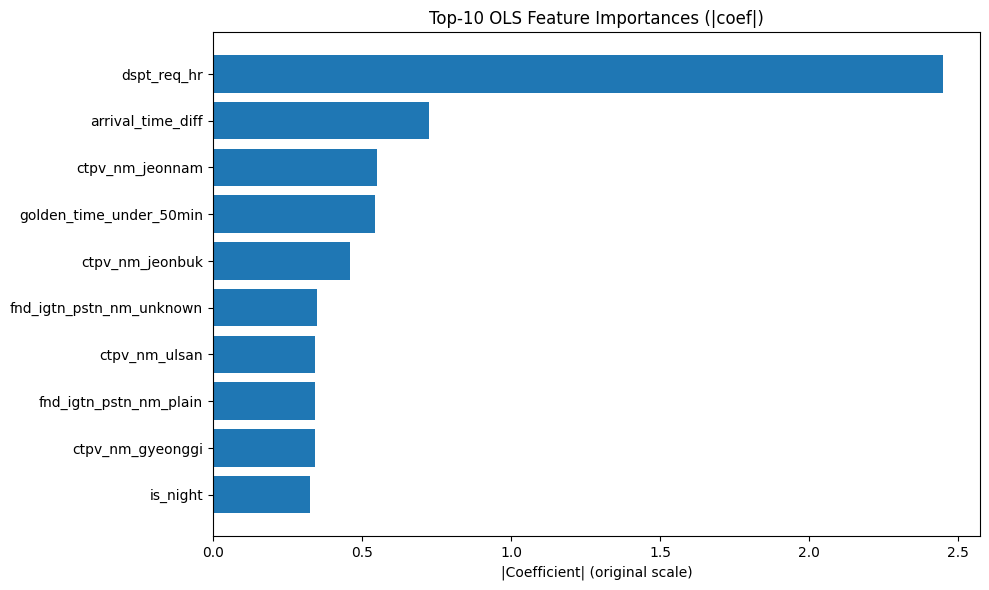


Top-10 Feature Importances (|coef|):


,feature,coef,abs_coef,sign
0,dspt_req_hr,-2.156725,2.156725,-1
1,arrival_time_diff,0.673621,0.673621,1
2,golden_time_under_50min,-0.552347,0.552347,-1
3,ctpv_nm_jeonnam,0.524386,0.524386,1
4,ctpv_nm_jeonbuk,0.439799,0.439799,1
5,fnd_igtn_pstn_nm_unknown,0.419828,0.419828,1
6,ctpv_nm_ulsan,-0.364429,0.364429,-1
7,ctpv_nm_gyeonggi,-0.361494,0.361494,-1
8,is_night,0.324472,0.324472,1
9,ctpv_nm_daejeon,-0.309608,0.309608,-1


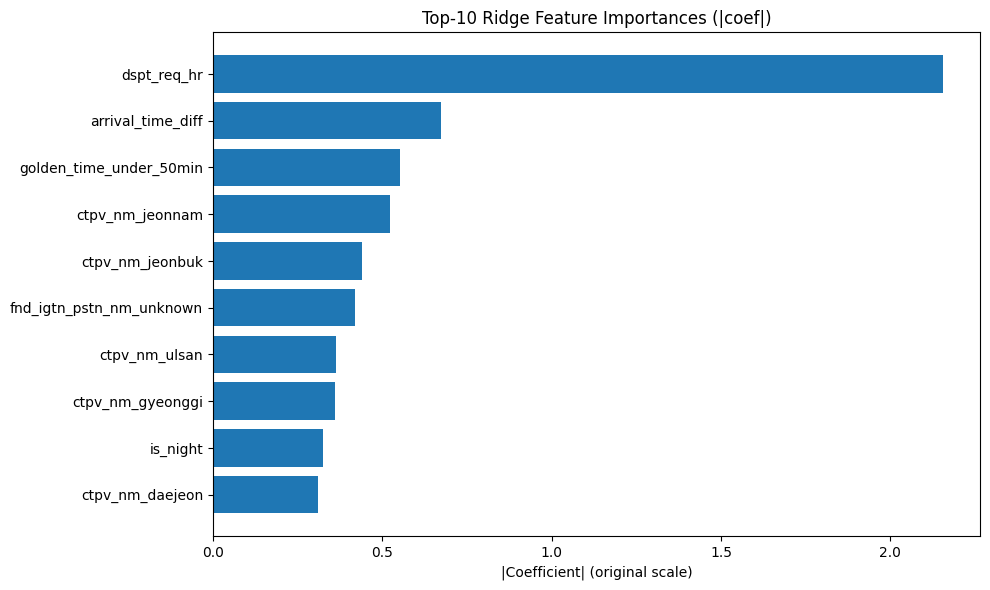


Top-10 Feature Importances (|coef|):


,feature,coef,abs_coef,sign
0,dspt_req_hr,-1.086679,1.086679,-1
1,golden_time_under_50min,-0.539523,0.539523,-1
2,arrival_time_diff,0.500656,0.500656,1
3,ctpv_nm_jeonnam,0.426705,0.426705,1
4,fnd_igtn_pstn_nm_plain,-0.407492,0.407492,-1
5,ctpv_nm_gyeonggi,-0.397094,0.397094,-1
6,ctpv_nm_jeonbuk,0.385570,0.385570,1
7,ctpv_nm_ulsan,-0.365886,0.365886,-1
8,ctpv_nm_seoul,-0.313006,0.313006,-1
9,is_night,0.302367,0.302367,1


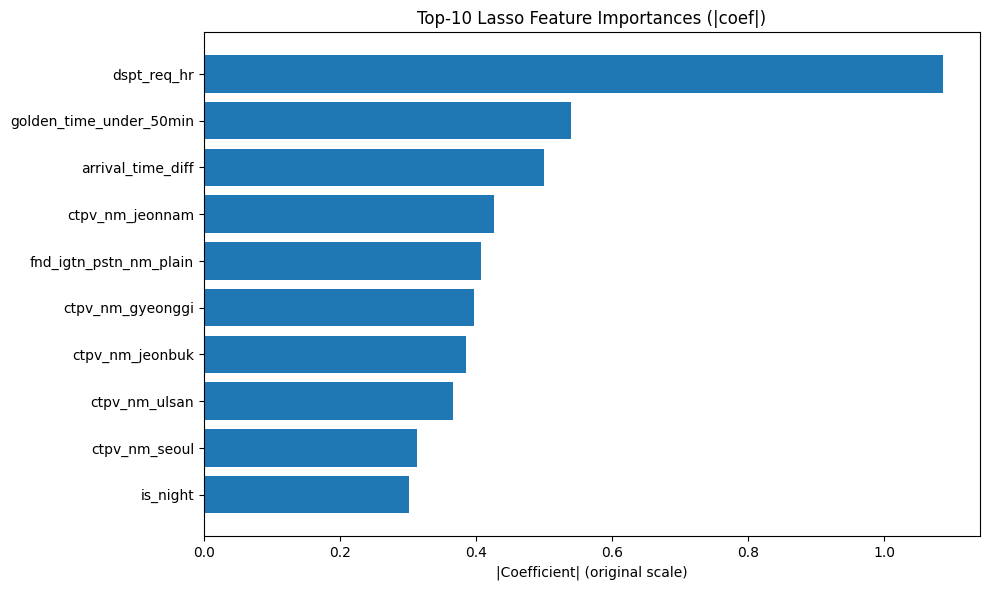

In [9]:
# === 4) 선형모델(OLS/Ridge/Lasso) 특성 중요도 Top-10 (|coef| 기준, 원 스케일) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

def _extract_linear_and_scaler(model):
    """Pipeline(StandardScaler → Linear) 또는 단일 Linear 모델에서 (linear, scaler) 추출"""
    if isinstance(model, Pipeline):
        # 마지막 스텝이 선형모델인지 확인
        last_est = model.steps[-1][1]
        if not isinstance(last_est, (LinearRegression, Ridge, Lasso)):
            raise TypeError("마지막 스텝이 LinearRegression/Ridge/Lasso가 아닙니다.")
        # 스케일러 찾기
        scaler = None
        for _, est in model.steps:
            if isinstance(est, StandardScaler) and hasattr(est, "scale_"):
                scaler = est
        return last_est, scaler
    else:
        if not isinstance(model, (LinearRegression, Ridge, Lasso)):
            raise TypeError("지원 모델: LinearRegression/Ridge/Lasso 또는 해당 파이프라인")
        return model, None

def _coef_to_original_scale(coef_std, intercept_std, scaler):
    """표준화 공간 계수 → 원 스케일로 복원"""
    if scaler is None:
        return coef_std, intercept_std
    scale = scaler.scale_
    mean  = scaler.mean_
    w_orig = coef_std / scale
    b_orig = intercept_std - np.sum((mean / scale) * coef_std)
    return w_orig, b_orig

def plot_linear_feature_importance(best_model, X, top_k=10, title="Linear Feature Importances (|coef|)"):
    """
    - best_model: OLS/Ridge/Lasso 또는 Pipeline(StandardScaler, Linear)
    - X: 학습에 사용한 DataFrame (컬럼명 필요)
    """
    assert isinstance(X, pd.DataFrame), "X는 컬럼명이 있는 DataFrame이어야 합니다."
    feature_cols = list(X.columns)

    lin, scaler = _extract_linear_and_scaler(best_model)
    coef_std = np.ravel(lin.coef_)
    intercept_std = float(lin.intercept_)

    coef_orig, intercept_orig = _coef_to_original_scale(coef_std, intercept_std, scaler)

    fi = pd.DataFrame({
        "feature": feature_cols,
        "coef": coef_orig,
        "abs_coef": np.abs(coef_orig),
        "sign": np.sign(coef_orig).astype(int)
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)

    print("\nTop-10 Feature Importances (|coef|):")
    display(fi.head(top_k))

    plt.figure(figsize=(10,6))
    top = fi.head(top_k).iloc[::-1]
    plt.barh(range(len(top)), top["abs_coef"])
    plt.yticks(range(len(top)), top["feature"])
    plt.xlabel("|Coefficient| (original scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return fi, intercept_orig

# === 실행: 세 모델 각각 출력 ===
fi_ols,   b0_ols   = plot_linear_feature_importance(best_model_ols,   X_train, top_k=10, title="Top-10 OLS Feature Importances (|coef|)")
fi_ridge, b0_ridge = plot_linear_feature_importance(best_model_ridge, X_train, top_k=10, title="Top-10 Ridge Feature Importances (|coef|)")
fi_lasso, b0_lasso = plot_linear_feature_importance(best_model_lasso, X_train, top_k=10, title="Top-10 Lasso Feature Importances (|coef|)")
